## Import Library

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import plotly.express as px
import matplotlib.pyplot as plt


## Insisiasi PySpark

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("StockAnalysis").getOrCreate()

def interactive_plot(df, title):
    pandas_df = df.toPandas()
    fig = px.line(pandas_df, x='Date', title=title)
    for i in pandas_df.columns[1:]:
        fig.add_scatter(x=pandas_df['Date'], y=pandas_df[i], name=i)
    fig.show()
    
def s_to_p(spark_df):
    pandas_df = spark_df.toPandas()
    return pandas_df

## Membaca Dataset

In [3]:
# Load IHSG dataset
stock_ihsg = spark.read.csv('../dataset/^JKSE.csv', header=True)
stock_ihsg = stock_ihsg.select('Date', 'Close').orderBy('Date')

## Visualisasi Dataset

In [4]:
# Show the first few rows
stock_ihsg.show()

# Show the bottom rows
bottom_rows = stock_ihsg.orderBy('Date', ascending=False).limit(5)
bottom_rows.show()

interactive_plot(stock_ihsg, 'Prices with Windowed Mean Fill')

+----------+-----------+
|      Date|      Close|
+----------+-----------+
|2019-01-04|6274.540039|
|2019-01-07|6287.224121|
|2019-01-08|6262.847168|
|2019-01-09|6272.237793|
|2019-01-10|6328.713867|
|2019-01-11|6361.464844|
|2019-01-14|6336.116211|
|2019-01-15|6408.784180|
|2019-01-16|6413.359863|
|2019-01-17|6423.779785|
|2019-01-18|6448.155762|
|2019-01-21|6450.833984|
|2019-01-22|6468.562012|
|2019-01-23|6451.169922|
|2019-01-24|6466.654785|
|2019-01-25|6482.842773|
|2019-01-28|6458.711914|
|2019-01-29|6436.479980|
|2019-01-30|6464.188965|
|2019-01-31|6532.969238|
+----------+-----------+
only showing top 20 rows

+----------+-----------+
|      Date|      Close|
+----------+-----------+
|2024-01-03|7279.090820|
|2024-01-02|7323.587891|
|2023-12-29|7272.796875|
|2023-12-28|7303.888184|
|2023-12-27|7245.916016|
+----------+-----------+



## Data Preprocessing: Missing Values

In [5]:
# Define the window size for calculating mean
window_size = 5
# Define a window specification
window_spec = Window.orderBy('Date').rowsBetween(-window_size, window_size)
# Replace empty strings with null values
stock_ihsg = stock_ihsg.withColumn('Close', when(col('Close') == 'null', None).otherwise(col('Close')))

# Create a new column 'Close' with missing values filled using windowed mean
stock_ihsg = stock_ihsg.withColumn(
    'Close',
    F.when(F.col('Close').isNull(), F.mean('Close').over(window_spec)).otherwise(F.col('Close'))
)
stock_ihsg = stock_ihsg.withColumnRenamed('Close', "IHSG")

interactive_plot(stock_ihsg, 'Prices with Mean Interpolated')

## Membaca Dataset Beberapa Saham


In [6]:
def load_and_process_stock_data(spark, ticker):
    # Load stock dataset
    stock_data = spark.read.csv(f'../dataset/{ticker}.JK.csv', header=True)
    stock_data = stock_data.select('Date', 'Close').orderBy('Date')
    
    # Replace empty strings with null values
    stock_data = stock_data.withColumn('Close', when(col('Close') == 'null', F.mean('Close').over(Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing))).otherwise(col('Close')))
    
    # Define the window size for calculating mean
    window_size = 5

    # Define a window specification
    window_spec = Window.orderBy('Date').rowsBetween(-window_size, window_size)

    # Create a new column 'Close' with missing values filled using windowed mean
    stock_data = stock_data.withColumn(
    'Close',
    F.when(F.col('Close').isNull(), F.mean('Close').over(window_spec)).otherwise(F.col('Close'))
)
    
    stock_data = stock_data.withColumnRenamed('Close', ticker)
    
    return stock_data

# Create a Spark session
spark = SparkSession.builder.appName("StockAnalysis").getOrCreate()

# List of stock tickers
stock_tickers = ['', 'BBCA', 'BBNI', 'ASII', 'UNVR', 'ICBP', 'INKP', 'TLKM']

# Load and process stock data for each ticker'

combined_stock = stock_ihsg

for ticker in stock_tickers[1:]:
    stock_data = load_and_process_stock_data(spark, ticker)
    combined_stock = combined_stock.join(stock_data, on='Date', how='inner')

# Show the combined DataFrame
combined_stock.show()

interactive_plot(combined_stock, 'Prices')


+----------+-----------+-----------+-----------+-----------+------------+------------+------------+-----------+
|      Date|       IHSG|       BBCA|       BBNI|       ASII|        UNVR|        ICBP|        INKP|       TLKM|
+----------+-----------+-----------+-----------+-----------+------------+------------+------------+-----------+
|2019-01-04|6274.540039|5205.000000|4362.500000|8350.000000| 9560.000000|10600.000000|11225.000000|3710.000000|
|2019-01-07|6287.224121|5245.000000|4437.500000|8150.000000| 9720.000000|10350.000000|11150.000000|3770.000000|
|2019-01-08|6262.847168|5240.000000|4450.000000|8175.000000| 9470.000000|10175.000000|11300.000000|3800.000000|
|2019-01-09|6272.237793|5255.000000|4425.000000|8200.000000| 9200.000000|10250.000000|11575.000000|3730.000000|
|2019-01-10|6328.713867|5255.000000|4425.000000|8200.000000| 9665.000000|10150.000000|12575.000000|3800.000000|
|2019-01-11|6361.464844|5250.000000|4462.500000|8300.000000| 9690.000000|10150.000000|12725.000000|3860.

## Data Preprocessing: Normalization

In [7]:
def normalize(df):
    first_row = df.first()
    normalized_df = df.withColumn(
        'Date',
        col('Date')
    )
    for col_name in df.columns[1:]:
        normalized_df = normalized_df.withColumn(
            col_name,
            col(col_name) / first_row[col_name]
        )
    return normalized_df

normalized_combined_stock = normalize(combined_stock)

# Show the normalized DataFrame
normalized_combined_stock.show()

+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|      Date|              IHSG|              BBCA|              BBNI|              ASII|              UNVR|              ICBP|              INKP|              TLKM|
+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|2019-01-04|               1.0|               1.0|               1.0|               1.0|               1.0|               1.0|               1.0|               1.0|
|2019-01-07|  1.00202151582764|1.0076849183477425|1.0171919770773639|0.9760479041916168|1.0167364016736402|0.9764150943396226|0.9933184855233853|1.0161725067385445|
|2019-01-08|0.9981364576642555|1.0067243035542748|1.0200573065902578|0.9790419161676647|0.9905857740585774|0.9599056603773585|1.0066815144766148|1.0242587601078168|
|2019-01-0

## Visualisasi Data Normalize

In [8]:
normalized_combined = s_to_p(normalized_combined_stock)
# Create an interactive plot using plotly
fig = px.line(normalized_combined, x='Date', y=normalized_combined.columns[1:],
              labels={'value': 'Normalized Price'},
              title='Normalized Stock Prices Over Time',
              line_shape="linear")
# Show the interactive plot
fig.show()

## Menganalisis Return Selama 5 Tahun

In [9]:
# Define a window specification to order the data by Date for each stock
window_spec = Window.partitionBy().orderBy("Date")

# List of stock columns excluding the Date column
stock_columns = combined_stock.columns[1:]

# Calculate the overall return for each stock
def overall_return(df):
    for stock_column in stock_columns:
        # Calculate the percentage change for each stock
        df = df.withColumn(stock_column + '_return', (F.col(stock_column) / F.first(stock_column).over(window_spec) - 1) * 100)

    # Select relevant columns
    return_columns = ['Date'] + [stock_column + '_return' for stock_column in stock_columns]
    result_df = df.select(return_columns)

    # Calculate the overall return percentage for each stock
    overall_return_df = result_df.groupBy().agg(
        *[F.last(stock_column + '_return').alias(stock_column + '_overall_return') for stock_column in stock_columns]
    )

    # Display the result in the desired format
    for stock_column in stock_columns:
        overall_return_value = overall_return_df.select(stock_column + '_overall_return').collect()[0][0]
        print(f"{stock_column} {overall_return_value}")

# Apply the overall_return function to the DataFrame
overall_return(combined_stock)

IHSG 16.009950924786832
BBCA 79.63496637848222
BBNI 22.636103151862464
ASII -32.93413173652695
UNVR -63.07531380753137
ICBP 0.2358490566037652
INKP -24.498886414253896
TLKM 6.738544474393526


## Menganalisis Return Harian

In [10]:
def calculate_daily_return_spark(df):
    # Langkah pertama: Copy DataFrame
    df_daily_return = df

    # Langkah kedua: Menghitung daily return
    for column in df.columns[1:]:
        # Menggunakan lag untuk mendapatkan nilai close pada hari sebelumnya
        df_daily_return = df_daily_return.withColumn("prev_day_close", F.lag(df[column]).over(Window().orderBy("Date")))
        
        # Menghitung daily return menggunakan rumus
        df_daily_return = df_daily_return.withColumn(column, ((df_daily_return[column] - df_daily_return["prev_day_close"]) / df_daily_return["prev_day_close"]) * 100)

    # Langkah ketiga: Set baris pertama menjadi 0
    df_daily_return = df_daily_return.na.fill(0)

    # Drop kolom prev_day_close
    df_daily_return = df_daily_return.drop("prev_day_close")

    return df_daily_return
# Misalkan combined_stock adalah DataFrame Anda
daily_combined_stock = calculate_daily_return_spark(combined_stock)

# Tampilkan DataFrame hasil
daily_combined_stock.show()

+----------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|      Date|                IHSG|                BBCA|               BBNI|               ASII|                UNVR|                ICBP|                INKP|               TLKM|
+----------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|2019-01-04|                 0.0|                 0.0|                0.0|                0.0|                 0.0|                 0.0|                 0.0|                0.0|
|2019-01-07|  0.2021515827640057|  0.7684918347742555| 1.7191977077363898|-2.3952095808383236|  1.6736401673640167|  -2.358490566037736| -0.6681514476614699| 1.6172506738544474|
|2019-01-08|-0.38772203011784373|-0.09532888465204957|0.28169014084507044| 0.3067484662576687|   -2.5720164609

## Visualisasi Daily Return

In [11]:
normalized_combined2 = s_to_p(daily_combined_stock)
# Create an interactive plot using plotly
fig = px.line(normalized_combined2, x='Date', y=normalized_combined2.columns[1:],
              labels={'value': 'Daily Return'},
              title='Daily Return Over Time',
              line_shape="linear")
# Show the interactive plot
fig.show()

## Correlation Analysis

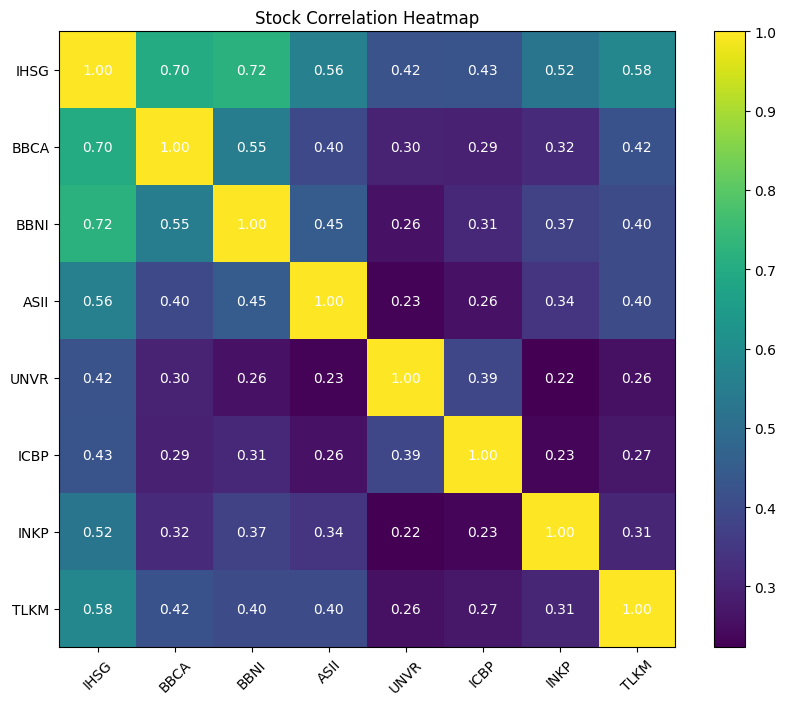

In [12]:
# Drop the 'Date' column
daily_combined_stock = daily_combined_stock.drop("Date")

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=daily_combined_stock.columns, outputCol="features")
assembled_data = assembler.transform(daily_combined_stock)

# Calculate correlation matrix
correlation_matrix = Correlation.corr(assembled_data, "features").head()

# Extract the correlation matrix as a NumPy array
correlation_array = correlation_matrix[0].toArray()

# Plot the heatmap with numbers inside the boxes
plt.figure(figsize=(10, 8))
plt.imshow(correlation_array, cmap="viridis", interpolation="nearest")
plt.title("Stock Correlation Heatmap")
plt.colorbar()

# Display the correlation values inside the boxes
for i in range(len(daily_combined_stock.columns)):
    for j in range(len(daily_combined_stock.columns)):
        plt.text(j, i, f"{correlation_array[i, j]:.2f}", ha="center", va="center", color="white")

plt.xticks(range(len(daily_combined_stock.columns)), daily_combined_stock.columns, rotation=45)
plt.yticks(range(len(daily_combined_stock.columns)), daily_combined_stock.columns)
plt.show()

## Histogram Analysis

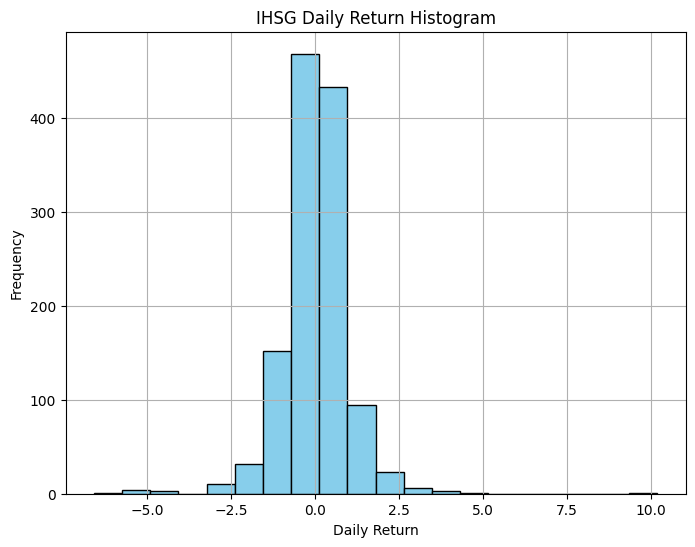

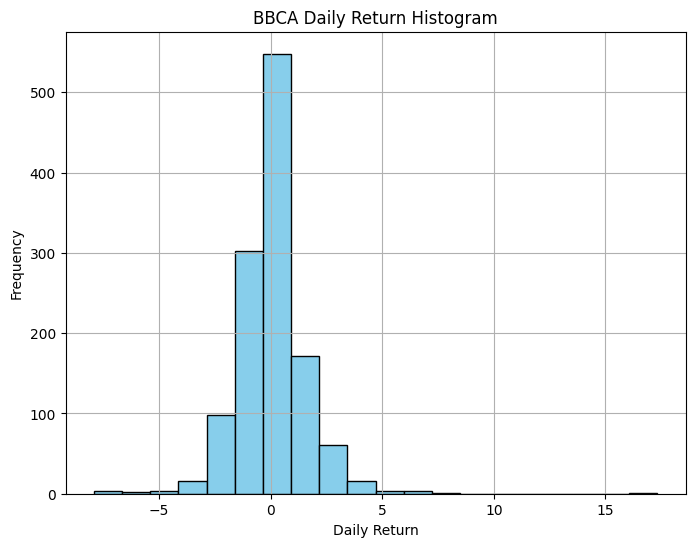

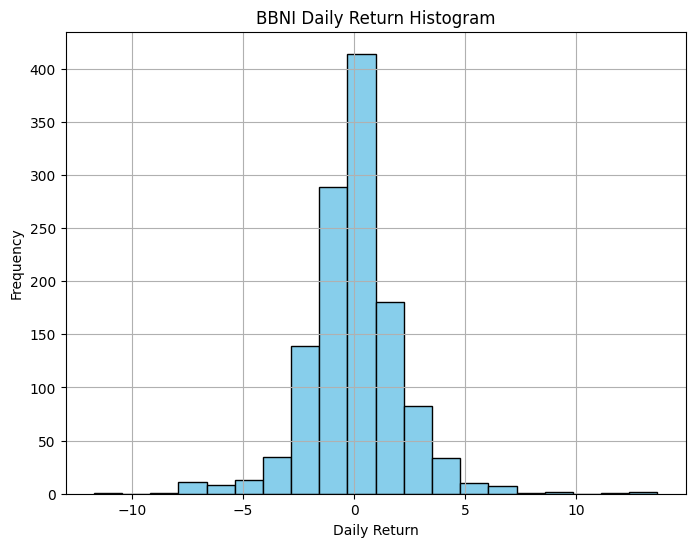

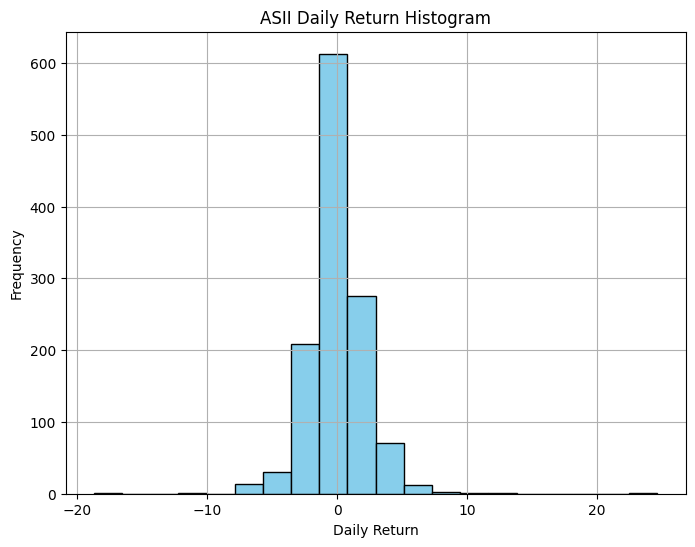

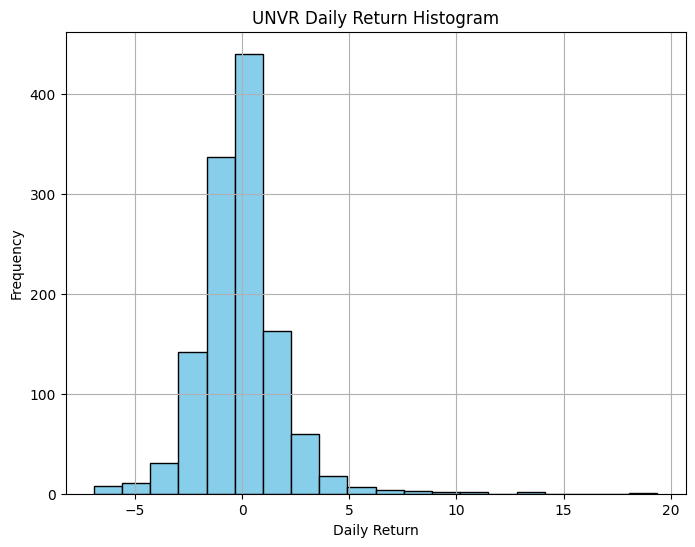

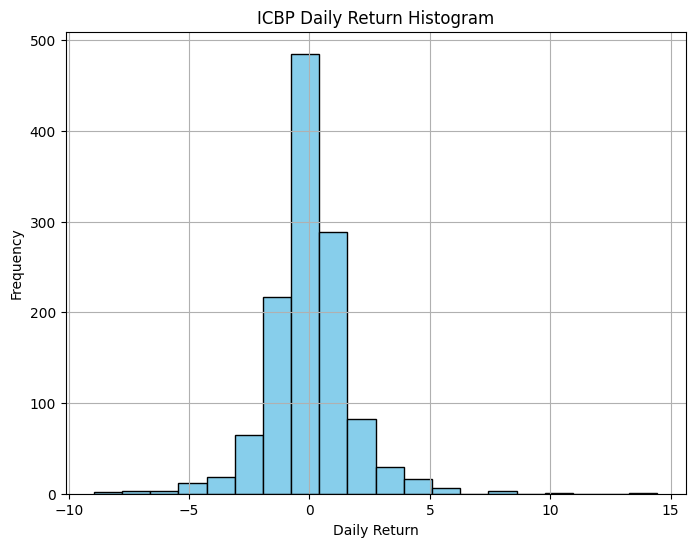

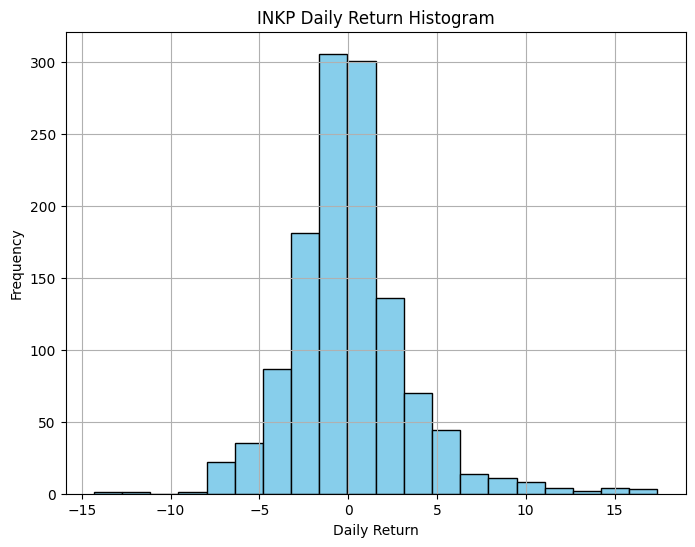

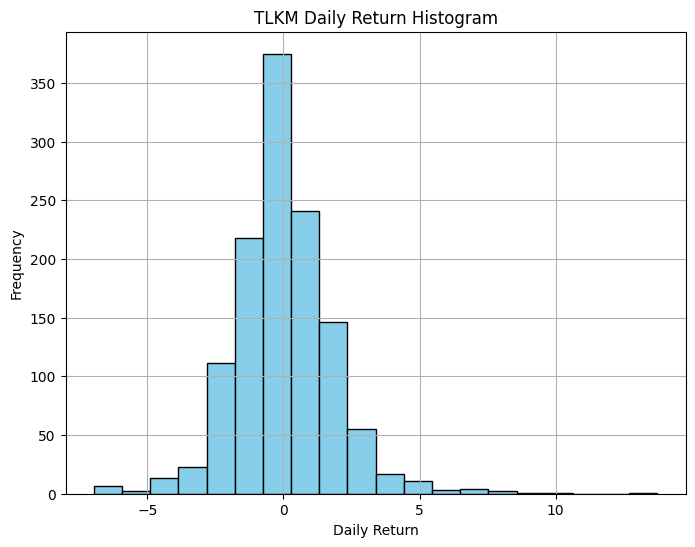

In [13]:
# Drop the 'Date' column
daily_combined_stock = daily_combined_stock.drop("Date")

# Loop through each stock column and create a histogram
for stock_column in daily_combined_stock.columns:
    # Extract the daily returns for the current stock
    stock_data = daily_combined_stock.select(stock_column).collect()
    stock_returns = [row[stock_column] for row in stock_data if row[stock_column] is not None]

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(stock_returns, bins=20, color='skyblue', edgecolor='black')
    plt.title(f"{stock_column} Daily Return Histogram")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()